In [29]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings

import sys
helios_source = '../../HELIOS/source'
if helios_source not in sys.path:
    sys.path.append(helios_source)
from species_database import species_lib

cmap = plt.get_cmap('viridis')
plt.rcParams['figure.dpi'] = 200

In [41]:
folder = "../output/EqChem/"
name = "Earth_P0=1e7_Tint=250_NoCond_CplusO=3.16e-1_CtoO=1.2"
path = f"{folder}{name}/" + "Static_Conc_{var}.dat"

# Load data
i = 0
step = 1

dimension = np.genfromtxt(path.format(var=i), dtype=int,  max_rows=1, skip_header=1)
print(dimension)
n_elem = dimension[0]
n_mol = dimension[1]
n_dust = dimension[2]
n_layers = dimension[3]

header = np.loadtxt(path.format(var=i), skiprows=2, max_rows=1, dtype=str)
atom_names = header[3:4+n_elem]
mol_names = header[4+n_elem:4+n_elem+n_mol]
dust_names = header[4+n_elem+n_mol:4+n_elem+n_mol+n_dust]
dust_names = np.array([dust_name[1:] for dust_name in dust_names]) # Remove first character (S)

inds = []
PTs = []
nHtots = []
data = []
atoms = []
mols = []
supersats = []
dusts = []
mus = []

print(path[:-21])

while True:
    with warnings.catch_warnings():
        warnings.simplefilter("error", UserWarning)
        try:
            d = np.loadtxt(path.format(var=i), skiprows=3)
            data.append(d)

            PTs.append(np.array([d[:,2]*1e-6, d[:,0]]).T) # convert pressure from dyn/cm^2 to bar
            nHtots.append(d[:,1])
            atoms.append(d[:,3:4+n_elem])
            mols.append(d[:,4+n_elem:4+n_elem+n_mol])
            supersats.append(d[:,4+n_elem+n_mol:4+n_elem+n_mol+n_dust])
            dusts.append(d[:,4+n_elem+n_mol+n_dust:4+n_elem+n_mol+2*n_dust])

            mu = path[:-21] + f'vertical_mix_{i}.dat'
            mu = np.loadtxt(mu, skiprows=1, usecols=3)
            mus.append(mu)

            inds.append(i)
            i += step
        except (FileNotFoundError, UserWarning):
            break

converted = False

[ 3 25  6 85]
../output/EqChem/Earth_P0=1e7_Tint=250_NoCond_CplusO=3.16e-1_CtoO=1.2/


In [42]:
print(len(header))
print(len(data))
print(data[0].shape)

print(header[3:4+n_elem])

if not converted:
    n_tots = []
    for i in range(len(data)):
        n_tot = 10**data[i][:, 3:4+n_elem+n_mol]
        n_tot = np.sum(n_tot, axis=1)
        n_tots.append(n_tot[:,None])

    # convert atomic abundances (log(cm^-3)) to mixing ratios
    for i, atom in enumerate(atoms):
        atom = 10**atom
        atoms[i] = atom / n_tots[i]
    
    # convert molecular abundances (log(cm^-3)) to mixing ratios
    for i, mol in enumerate(mols):
        mol = 10**mol
        mols[i] = mol / n_tots[i]

    #for i in range(len(supersats)):
    #    supersats[i] = 10**supersats[i]

    for i in range(len(dusts)):
        dusts[i] = 10**(dusts[i]) * nHtots[i][:,None] / n_tots[i]
    
    converted = True


51
12
(85, 51)
['el' 'H' 'C' 'O']


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] 11
250.0
1688.99
1085.95
1086.86
1087.32
1087.55
1087.66
1087.72
1087.75
1087.76
1087.77
1087.77


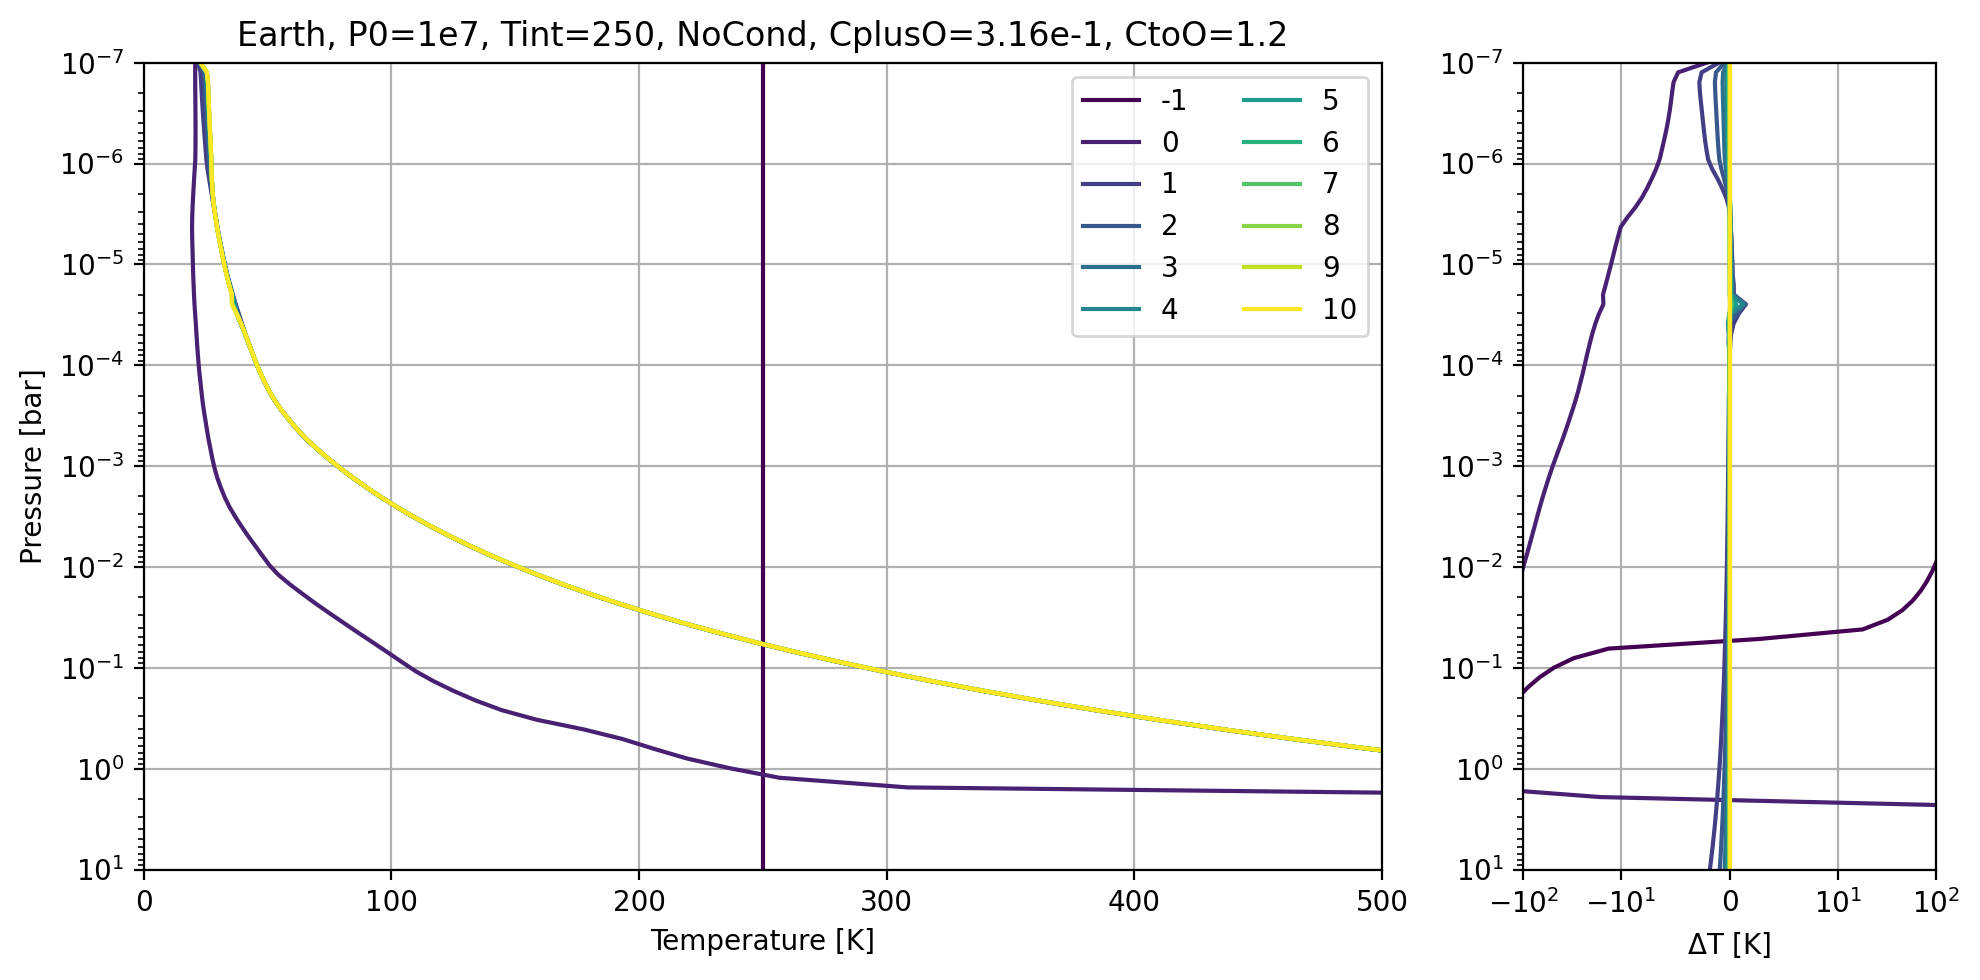

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(10, 5))

start = 0
step = 1
stop = len(PTs)

sel_inds = inds[start:stop:step]
print(inds, sel_inds[-1])

for i, pt in enumerate(PTs[start:stop:step]):
    print(pt[0,1])
    ax1.plot(pt[:,1], pt[:,0], label=f"{sel_inds[i]-1}", color=cmap(i*step/np.maximum((stop-start-1),1)))

ax1.legend(ncols=2)
ax1.invert_yaxis()
ax1.set_yscale("log")
#ax1.set_xscale("log")
ax1.set_xlim(0, 500)
ax1.set_ylim(PTs[0][0,0], PTs[0][-1,0]*1e0)
#ax1.set_xticks(np.arange(500, 3500, 100), minor=True)
#ax1.set_xticks(np.arange(800, 3201, 400))

ax1.set_xlabel("Temperature [K]")
ax1.set_ylabel("Pressure [bar]")
ax1.set_title(name.replace("_", ", "))
ax1.grid()

# Plot differences in the slimmer column
for i, pt in enumerate(PTs[start:stop:step]):
    diff = pt[:,1]-PTs[sel_inds[-1]][:,1]
    ax2.plot(diff, pt[:,0], label=f"{sel_inds[i]}-{sel_inds[-1]}", color=cmap(i*step/np.maximum((stop-start-1),1)))

ax2.invert_yaxis()
ax2.set_xscale("symlog", linthresh=1e1)
ax2.set_yscale("log")
ax2.set_xlim(-100, 100)
ax2.set_ylim(PTs[0][0,0], PTs[0][-1,0]*1e0)
ax2.set_xlabel(r"$\Delta$T [K]")
#ax2.set_title("Difference")
ax2.grid()

plt.tight_layout()
plt.show()

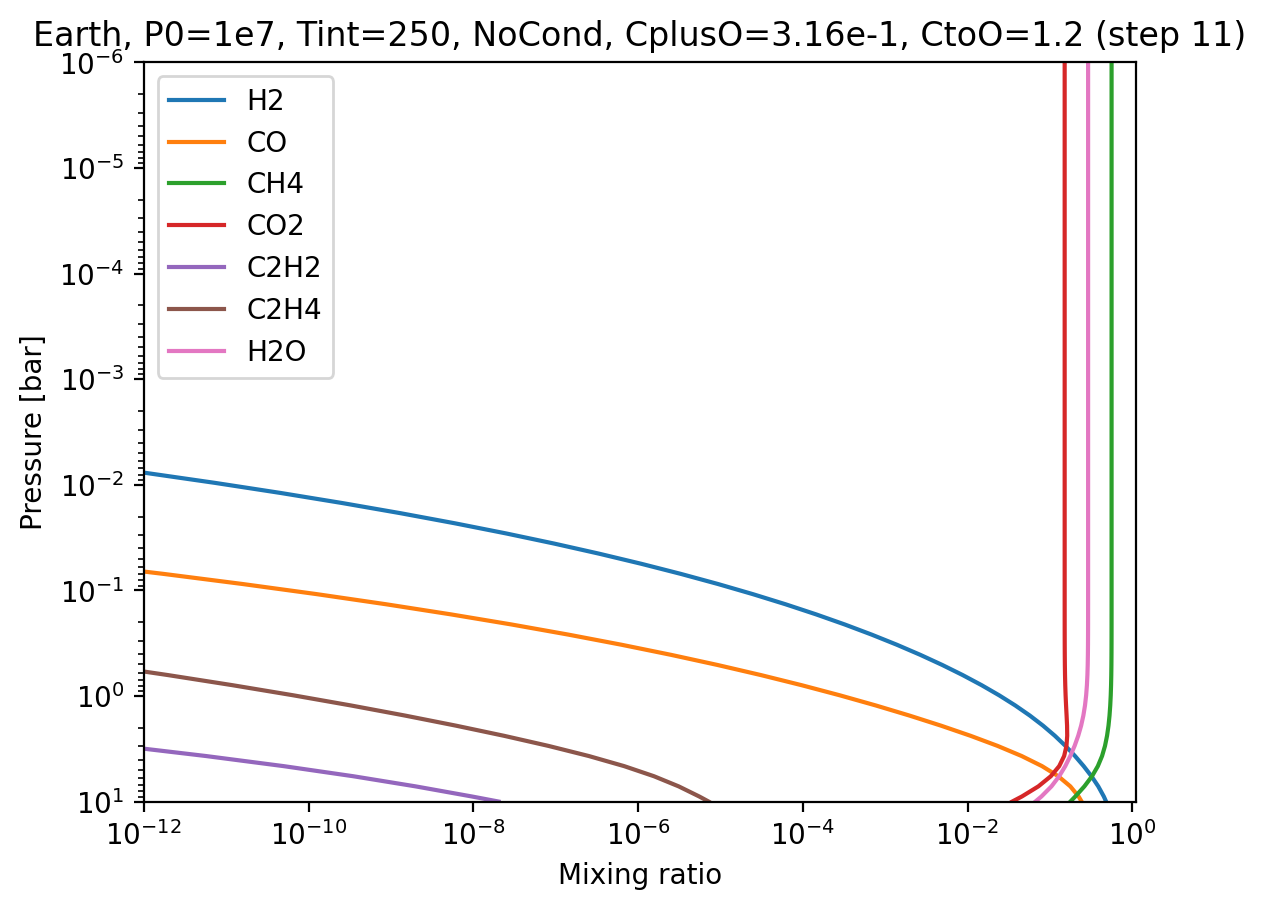

In [44]:
# plot mixing ratios for certain step
i = len(mols)-1
plot_mass_mr = False

threshold = None

if threshold is not None:
    mask = mols[i] > threshold
    mask = np.any(mask, axis=0)
else:
    target_molecules = ['H2', 'H2O', 'CO2', 'CO', 'CH4', 'C2H2', 'C2H4']
    mask = np.isin(mol_names, target_molecules)
    #sort = np.argsort(mols[i][:,mask].max(axis=0))[::-1]

if plot_mass_mr:
    try:
        masses = [species_lib[name].weight for name in mol_names[mask]]
    except:
        raise KeyError("Error calculating mass: molecule name not found.")

    plt.plot(mols[i][:,mask]*masses/mus[i][:,None], PTs[i][:,0], label=mol_names[mask])
else:
    plt.plot(mols[i][:,mask], PTs[i][:,0], label=mol_names[mask])

xlog = True
if xlog:
    plt.xscale('log')
    plt.xlim(1e-12, 1.1e0)
else:
    plt.xlim(0, 1.05)

plt.yscale('log')
plt.ylim(PTs[0][0,0], PTs[0][-1,0]*1e1)

if plot_mass_mr:
    plt.xlabel('Mass mixing ratio')
else:
    plt.xlabel('Mixing ratio')
plt.ylabel('Pressure [bar]')
#plt.title(f'Mass mixing ratios for step {i}')
plt.title(name.replace("_", ", ") + f' (step {i})')

plt.legend()

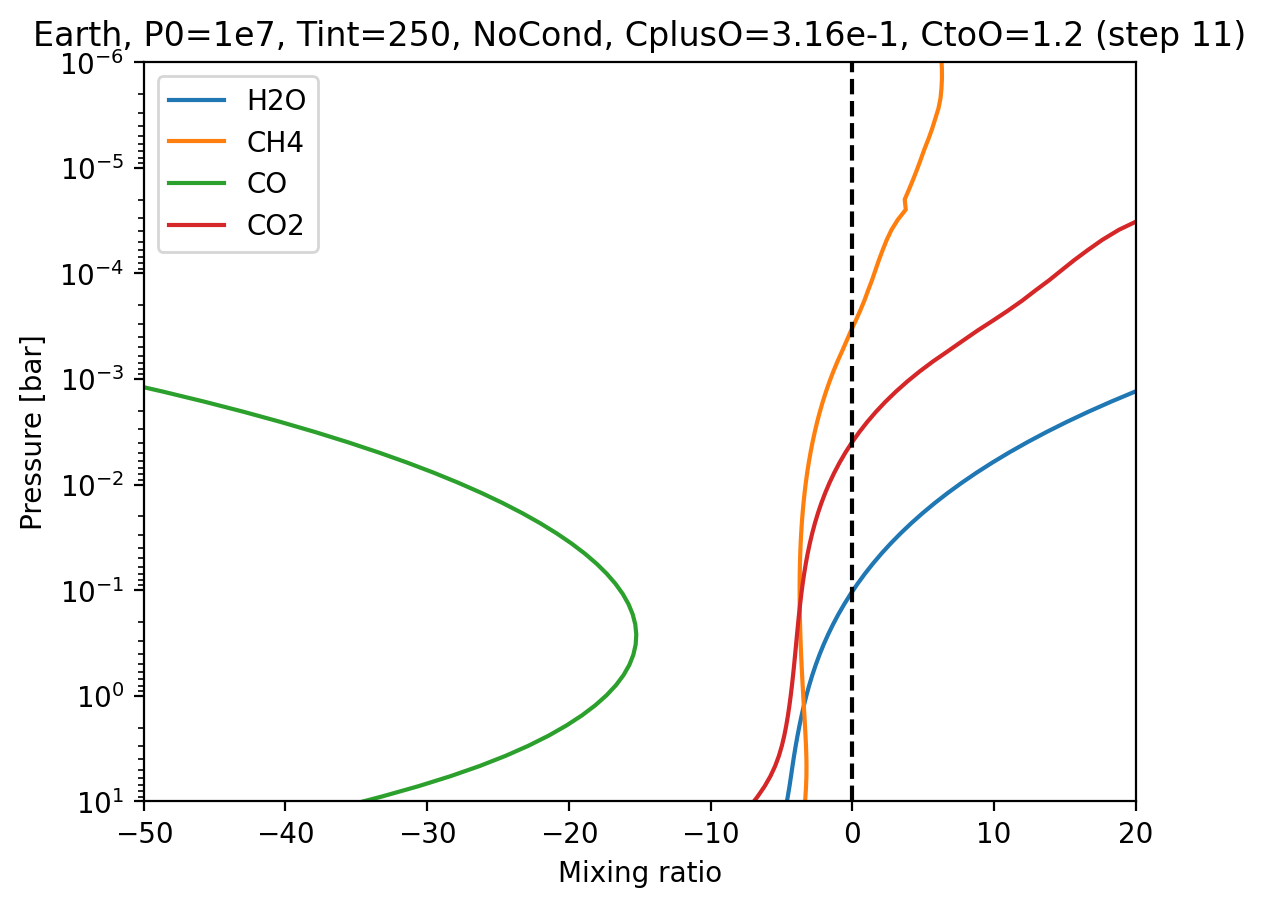

In [45]:
# plot the supersaturation ratios
i = len(mols)-1

threshold = None

if threshold is not None:
    mask = mols[i] > threshold
    mask = np.any(mask, axis=0)
else:
    target_molecules = ['H2', 'H2O', 'CO2', 'CO', 'CH4', 'C2H2', 'C2H4']
    mask = np.isin(dust_names, target_molecules)
    #sort = np.argsort(mols[i][:,mask].max(axis=0))[::-1]

#print(supersats[i][:,mask])
plt.plot(supersats[i][:,mask], PTs[i][:,0], label=dust_names[mask])
plt.vlines(0, PTs[i][0,0], PTs[i][-1,0], linestyle='dashed', color='black')

plt.xlim(-50, 20)

plt.yscale('log')
plt.ylim(PTs[0][0,0], PTs[0][-1,0]*1e1)

if plot_mass_mr:
    plt.xlabel('Mass mixing ratio')
else:
    plt.xlabel('Mixing ratio')
plt.ylabel('Pressure [bar]')
#plt.title(f'Mass mixing ratios for step {i}')
plt.title(name.replace("_", ", ") + f' (step {i})')

plt.legend()